# Unstructured Data Analysis Final Assessment - Product comparison using Sentiment Analysis

### 1. Data Extraction 

We will first train the NLP model using Amazon product reviews from <i> J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013</i>. Web link - https://snap.stanford.edu/data/web-Amazon-links.html This includes the review data from June 1995 to Mar 2013. 

In [248]:
import numpy 
numpy.random.seed(30224) 

from bs4 import BeautifulSoup
import requests

import pandas as pd
from collections import defaultdict

def scrape_amazon_reviews(asins):
    '''
        Method to scrape review page given an asin  

        Parameters
        asins - List of Amazon Unique id for a product 

        Returns 
        review_df - Pandas dataframe with columns 
            asin - asin of the product 
            rating - rating of the review 
            review_text - review text 
    '''
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0",
           "Accept-Encoding":"gzip, deflate", 
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
           "DNT":"1",
           "Connection":"close", 
           "Upgrade-Insecure-Requests":"1"}
    
    df_list = []
    for asin_info in asins: 
        asin = asin_info['asin']
        product_name = asin_info['product_name']
        d = defaultdict(list)
        url = f'https://www.amazon.com/product-reviews/{asin}/'
        response = requests.get(url, headers = headers)
        if(response.status_code != 200):
            print(response)
        soupified = BeautifulSoup(response.text, "html.parser")
        reviews = soupified.find_all("div",{"data-hook":"review"})
        for review in reviews:
            review_rating = float(review.find("span", {"class" : "a-icon-alt"}).get_text().strip().split()[0])
            review_text = review.find("span", {"class" : "review-text"}).get_text().strip()
            d['asin'].append(asin)
            d['product_name'].append(product_name)
            d['rating'].append(review_rating)
            d['review_text'].append(review_text)
        df = pd.DataFrame(d)
        df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

        
asins = [{'asin':'B0BS1QCFHX',
          'product_name': 'Sony WH-CH720N'},
          {'asin':'B0C6KKQ7ND',
           'product_name': 'Soundcore Space One'}]

reviews_df = scrape_amazon_reviews(asins)
reviews_df.shape

(20, 4)

In [249]:
# sentence tokenize and create row for each sentence 
# (each sentence to be treated as aspect)
import spacy
nlp = spacy.load("en_core_web_sm")

reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x : [sent.text for sent in nlp(x).sents])
reviews_df = reviews_df.explode('review_text').reset_index(drop=True)
reviews_df

,asin,product_name,rating,review_text
0,B0BS1QCFHX,Sony WH-CH720N,5.0,I had the Soundcore by Anker Life Q35 ANC Headphones.
1,B0BS1QCFHX,Sony WH-CH720N,5.0,I liked them.
2,B0BS1QCFHX,Sony WH-CH720N,5.0,ANC was great.
3,B0BS1QCFHX,Sony WH-CH720N,5.0,"and while stock they were a little bass boomy, they EQed out just fine."
4,B0BS1QCFHX,Sony WH-CH720N,5.0,"The only issue I had was at the 1 year point, the plastic it was made out of started falling apart."
...,...,...,...,...
712,B0C6KKQ7ND,Soundcore Space One,4.0,With my q30s on all of the same settings I have bass and mids on their own and still have the treble separate and it doesn't sound like a tin can and the audio is centered.
713,B0C6KKQ7ND,Soundcore Space One,4.0,I'm not expecting a huge soundstage from $100 headphones but at least try.
714,B0C6KKQ7ND,Soundcore Space One,4.0,Maybe the ANC is better?
715,B0C6KKQ7ND,Soundcore Space One,4.0,As an avid spoundcore user (have three over the ears two in ears in the house) these are going back and I def won't recommend them.


### 2. EDA and Data cleanup 
We will filter required values, merge fields, do visualization

In [364]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("words")
stop_words = set(stopwords.words('english'))
common_words = ['headphone', 'headphon','soundcor','soni','bit','say','anker','phone','thing','use','tri','set','still','would']
stemmer = PorterStemmer()
words = set(nltk.corpus.words.words())

def review_pre_process(line): 
    '''
    Method to pre process document line including case change, removal of non-alphabetic 
    characters, smaller words, stop words and then stemming it. 

    Input   : line of text as String 
    Returns : pre-processed line as String 
    '''
    line = line.lower() # convert to lower case 
    line = re.sub("[^a-z]", " ", line) # remove non alpha 
    tokens = line.split()
    # tokens = [i for i in tokens if i in words] # only english and alpha 
    tokens = [i for i in tokens if not i in stop_words and not i in common_words] # remove stop words 
    tokens = [i for i in tokens if len(i)>2] # remove small words 
    tokens = [stemmer.stem(i) for i in tokens] #stem words 
    tokens = [i for i in tokens if not i in stop_words and not i in common_words] #remove stop words again 
    cleaned = " ".join(tokens)
    return cleaned
reviews_df['cleaned_review'] = reviews_df['review_text'].apply(review_pre_process)
# remove lines which are too short 
reviews_df = reviews_df.drop(reviews_df[reviews_df['cleaned_review'].apply(lambda x: len(x.split())== 1)].index)
reviews_df

[nltk_data] Downloading package words to /Users/jkannan/nltk_data...
[nltk_data]   Package words is already up-to-date!


,asin,product_name,rating,review_text,cleaned_review,aspects,aspect
0,B0BS1QCFHX,Sony WH-CH720N,5.0,I had the Soundcore by Anker Life Q35 ANC Headphones.,life anc,"[(0, 0.7308183), (1, 0.06742352), (2, 0.06694637), (3, 0.06724821), (4, 0.06756359)]",0
2,B0BS1QCFHX,Sony WH-CH720N,5.0,ANC was great.,anc great,"[(0, 0.7292904), (1, 0.06762645), (2, 0.06668906), (3, 0.06842638), (4, 0.067967735)]",0
3,B0BS1QCFHX,Sony WH-CH720N,5.0,"and while stock they were a little bass boomy, they EQed out just fine.",stock littl bass boomi eqe fine,"[(0, 0.029969782), (1, 0.8801751), (2, 0.02928237), (3, 0.03063238), (4, 0.029940363)]",1
4,B0BS1QCFHX,Sony WH-CH720N,5.0,"The only issue I had was at the 1 year point, the plastic it was made out of started falling apart.",issu year point plastic made start fall apart,"[(0, 0.02237733), (1, 0.02259756), (2, 0.9097996), (3, 0.02241617), (4, 0.0228093)]",2
5,B0BS1QCFHX,Sony WH-CH720N,5.0,I had 3 pieces of the headset fall apart until it finally broke enough that I couldn't wear them.,piec headset fall apart final broke enough wear,"[(0, 0.022434678), (1, 0.022303754), (2, 0.91012347), (3, 0.022812992), (4, 0.022325104)]",2
...,...,...,...,...,...,...,...
711,B0C6KKQ7ND,Soundcore Space One,4.0,The sound is a little more on the left and using the signature setting from the app it sounds like all of the audio was dumped into a bucket.,sound littl left signatur app sound like audio dump bucket,"[(0, 0.018467348), (1, 0.018335314), (2, 0.0182326), (3, 0.018546151), (4, 0.9264186)]",4
712,B0C6KKQ7ND,Soundcore Space One,4.0,With my q30s on all of the same settings I have bass and mids on their own and still have the treble separate and it doesn't sound like a tin can and the audio is centered.,bass mid trebl separ sound like tin audio center,"[(0, 0.020959549), (1, 0.020209286), (2, 0.02014154), (3, 0.020298462), (4, 0.91839117)]",4
713,B0C6KKQ7ND,Soundcore Space One,4.0,I'm not expecting a huge soundstage from $100 headphones but at least try.,expect huge soundstag least,"[(0, 0.8384796), (1, 0.040824205), (2, 0.040063877), (3, 0.040231705), (4, 0.04040065)]",0
714,B0C6KKQ7ND,Soundcore Space One,4.0,Maybe the ANC is better?,mayb anc better,"[(0, 0.051020525), (1, 0.051002435), (2, 0.050647993), (3, 0.05067405), (4, 0.796655)]",4


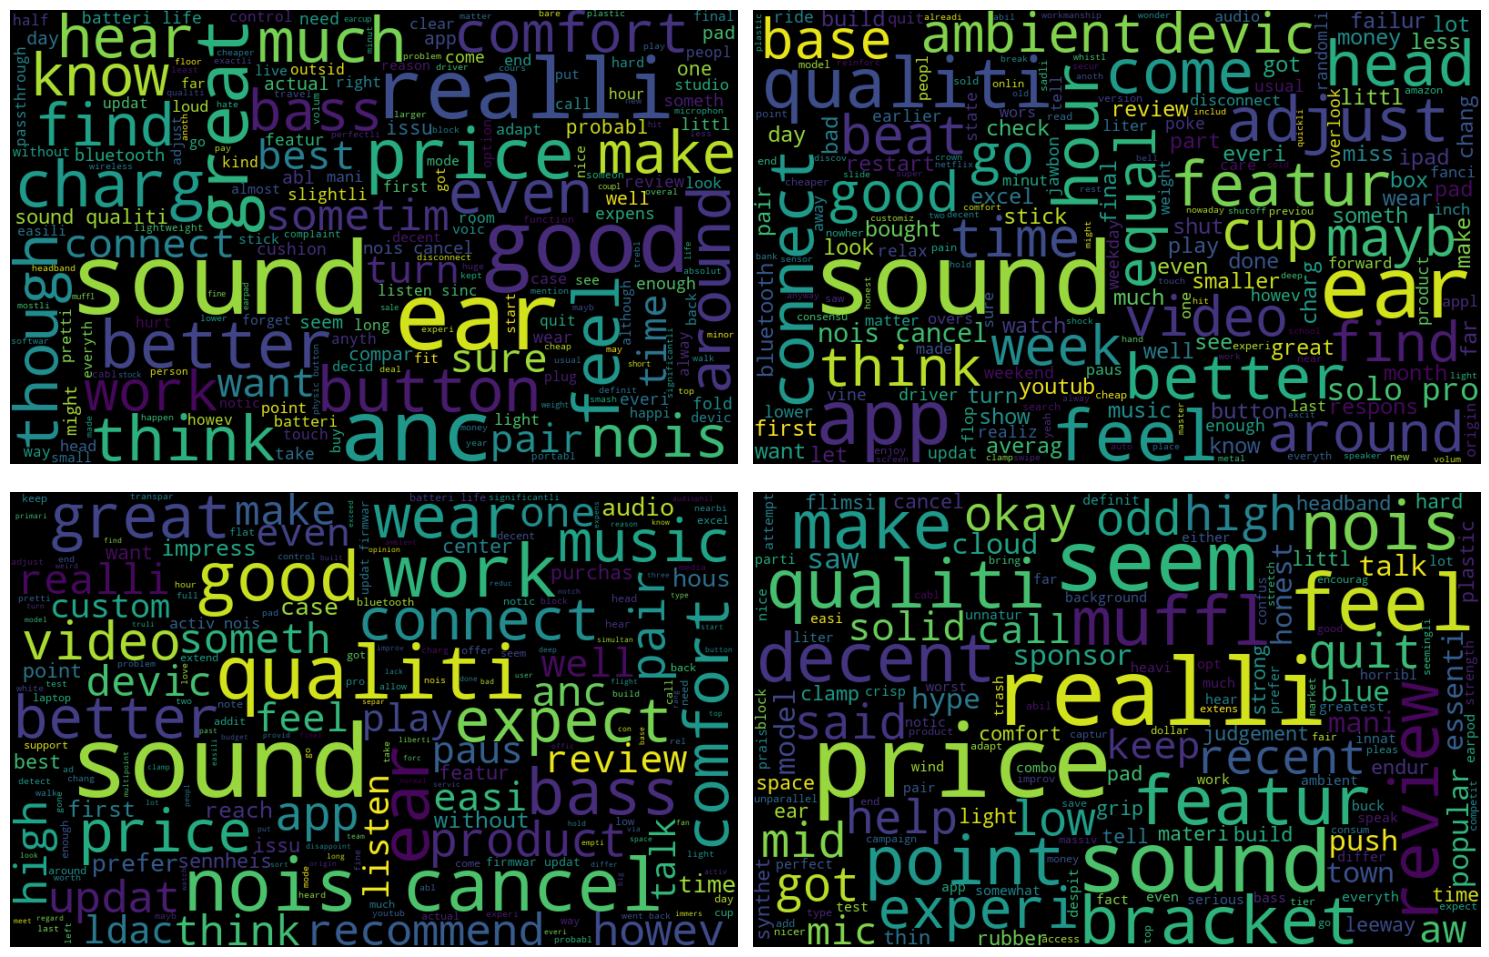

In [365]:
# visualization

from wordcloud import WordCloud
import matplotlib.pyplot as plt 

pos_asin0_words = '.'.join(reviews_df[(reviews_df['rating'] > 3) & reviews_df["asin"].str.contains(asins[0]["asin"])]['cleaned_review'].to_list())
neg_asin0_words = '.'.join(reviews_df[(reviews_df['rating'] < 4) & reviews_df["asin"].str.contains(asins[0]["asin"])]['cleaned_review'].to_list())
pos_asin1_words = '.'.join(reviews_df[(reviews_df['rating'] > 3) & reviews_df["asin"].str.contains(asins[1]["asin"])]['cleaned_review'].to_list())
neg_asin1_words = '.'.join(reviews_df[(reviews_df['rating'] < 4) & reviews_df["asin"].str.contains(asins[1]["asin"])]['cleaned_review'].to_list())
word_groups = [pos_asin0_words, neg_asin0_words, pos_asin1_words, neg_asin1_words]

figure, axis = plt.subplots(2, 2, figsize=(15,10),  tight_layout=True)
axs = axis.flat
for (ax, words,i) in zip(axs,word_groups,range(4)):
    wordcloud = WordCloud(width=800, height=500, random_state=2023, max_font_size=110).generate(words)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
plt.show()


### 3. Aspect Word identification using LDA 
We will use Latent Dirichlet Allocation algorithm to identify Latent aspects used by 
users in coming up the review. 

In [366]:
# Latent aspect identification

from gensim.test.utils import common_texts
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from collections import Counter

docs = reviews_df['cleaned_review']
docs_tok = docs.apply(lambda x: x.split())
docs_tok.head()

common_dictionary = Dictionary(docs_tok)
common_corpus = [common_dictionary.doc2bow(text) for text in docs_tok]
common_corpus

num_topics = 5
lda_model = LdaMulticore(corpus=common_corpus,
                         id2word=common_dictionary,
                         num_topics=num_topics,
                        passes=10)

topics = lda_model.show_topics(formatted=False)
for i in range(num_topics):
    print(f"Topic:{topics[i][0]} Words:{topics[i][1][:5]}")


Topic:0 Words:[('like', 0.017363986), ('good', 0.016488943), ('nois', 0.01511302), ('great', 0.013789706), ('anc', 0.013676529)]
Topic:1 Words:[('ear', 0.032590542), ('charg', 0.020533528), ('day', 0.012486654), ('light', 0.011958716), ('like', 0.009496572)]
Topic:2 Words:[('price', 0.019440223), ('updat', 0.014430938), ('like', 0.01149761), ('even', 0.01146789), ('point', 0.010942774)]
Topic:3 Words:[('nois', 0.022989515), ('button', 0.015670788), ('cancel', 0.015507046), ('work', 0.014083642), ('much', 0.011182055)]
Topic:4 Words:[('sound', 0.058178727), ('bass', 0.020830788), ('qualiti', 0.015756266), ('better', 0.014491764), ('good', 0.014190693)]


In [367]:
# Latent aspect assignment for each sentence of review 
reviews_df['aspects'] = [lda_model[corpus_i] for corpus_i in common_corpus]
reviews_df['aspect'] = [max(aspects_i, key=lambda item: item[1])[0] for aspects_i in reviews_df['aspects']]
reviews_df

,asin,product_name,rating,review_text,cleaned_review,aspects,aspect
0,B0BS1QCFHX,Sony WH-CH720N,5.0,I had the Soundcore by Anker Life Q35 ANC Headphones.,life anc,"[(0, 0.06845777), (1, 0.066883095), (2, 0.06694307), (3, 0.06760116), (4, 0.73011494)]",4
2,B0BS1QCFHX,Sony WH-CH720N,5.0,ANC was great.,anc great,"[(0, 0.7305673), (1, 0.06731985), (2, 0.066842906), (3, 0.067553245), (4, 0.067716725)]",0
3,B0BS1QCFHX,Sony WH-CH720N,5.0,"and while stock they were a little bass boomy, they EQed out just fine.",stock littl bass boomi eqe fine,"[(0, 0.028616846), (1, 0.028579045), (2, 0.02879559), (3, 0.029771682), (4, 0.8842368)]",4
4,B0BS1QCFHX,Sony WH-CH720N,5.0,"The only issue I had was at the 1 year point, the plastic it was made out of started falling apart.",issu year point plastic made start fall apart,"[(0, 0.022581581), (1, 0.022268962), (2, 0.022932524), (3, 0.022943731), (4, 0.90927315)]",4
5,B0BS1QCFHX,Sony WH-CH720N,5.0,I had 3 pieces of the headset fall apart until it finally broke enough that I couldn't wear them.,piec headset fall apart final broke enough wear,"[(0, 0.9093878), (1, 0.022311835), (2, 0.022579324), (3, 0.022430513), (4, 0.023290504)]",0
...,...,...,...,...,...,...,...
711,B0C6KKQ7ND,Soundcore Space One,4.0,The sound is a little more on the left and using the signature setting from the app it sounds like all of the audio was dumped into a bucket.,sound littl left signatur app sound like audio dump bucket,"[(0, 0.018463884), (1, 0.018300608), (2, 0.018464554), (3, 0.018404618), (4, 0.9263663)]",4
712,B0C6KKQ7ND,Soundcore Space One,4.0,With my q30s on all of the same settings I have bass and mids on their own and still have the treble separate and it doesn't sound like a tin can and the audio is centered.,bass mid trebl separ sound like tin audio center,"[(0, 0.02015038), (1, 0.02010477), (2, 0.020158013), (3, 0.020110527), (4, 0.9194763)]",4
713,B0C6KKQ7ND,Soundcore Space One,4.0,I'm not expecting a huge soundstage from $100 headphones but at least try.,expect huge soundstag least,"[(0, 0.8392181), (1, 0.040279716), (2, 0.040053558), (3, 0.040106256), (4, 0.040342405)]",0
714,B0C6KKQ7ND,Soundcore Space One,4.0,Maybe the ANC is better?,mayb anc better,"[(0, 0.050989136), (1, 0.050117314), (2, 0.051037893), (3, 0.7946059), (4, 0.05324973)]",3


### 4. Rating for Latent Aspects
We will use sentence level Aspect along with Rating for the review to determine the aspect level rating 
for each review, which can be averaged to get overall aspect level average rating 

In [368]:
pd.pivot_table(reviews_df, values='rating', index='aspect', columns='product_name')

product_name,Sony WH-CH720N,Soundcore Space One
aspect,,
0,4.476190,4.219512
1,4.485294,4.250000
2,4.395062,3.959184
3,4.620000,4.236842
4,4.482759,4.245614


In [372]:
pd.set_option("display.max_colwidth",None)
interested_aspect = 2
filtered_df = reviews_df[reviews_df['aspect']==interested_aspect]
filtered_df = filtered_df.sort_values(by=['asin','rating'])
high_rating_text = filtered_df.groupby(['asin']).tail(4)[['product_name','rating','review_text']]
low_rating_text = filtered_df.groupby(['asin']).head(4)[['product_name','rating','review_text']]
aspect_reviews = pd.concat([high_rating_text, low_rating_text])
aspect_reviews


,product_name,rating,review_text
343,Sony WH-CH720N,5.0,"Multipoint connection is also a very nice plus if, say, I am working at my computer and still want to be able to answer phone calls hands-free."
356,Sony WH-CH720N,5.0,My final and complaint is with the microphone for phone calls.
362,Sony WH-CH720N,5.0,I'd have paid upwards of twice the price for what I got.
370,Sony WH-CH720N,5.0,hard to beat.
535,Soundcore Space One,5.0,"The build is decent and comfortable, making them ideal for long flights or commutes."
607,Soundcore Space One,5.0,"Additionally to note, they do not come with a case so I do recommend to buy a good quality case to extend the life of headphones."
614,Soundcore Space One,5.0,"And if you want something more of decent headphone that doesn't muffle everything this is not it, even Q30 is a overall better choice than this especially in the sound department."
652,Soundcore Space One,5.0,"Soundcore has exceeded my expectations, delivering a fantastic blend of performance and comfort."
374,Sony WH-CH720N,3.0,Update 3/9……so first I’m going to say that I bought these with my own money before any reviews were out.
376,Sony WH-CH720N,3.0,After a few weeks of use the padding has relaxed enough so that I can feel the drivers poking my ears.
